In [1]:
from sqlalchemy import create_engine
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from matplotlib import pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

In [30]:
class Interpolator(BaseEstimator, TransformerMixin):
    def __init__(self, freq: str):
        self.freq = freq
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Check if the passed Dataframe has the corrct format
        if not isinstance(X, pd.DataFrame):
            raise TypeError("Expecting a pandas DataFrame")
        if not isinstance(X.index, pd.DatetimeIndex):
            raise ValueError("DataFrame index should be a DatetimeIndex")
        
        # Calculate Timestamps for the given Frequency
        start_date = X.index.min().floor(self.freq)
        end_date = X.index.max()
        all_hours = pd.date_range(start=start_date, end=end_date, freq=self.freq)
        
        # Combine the given Data with the generated Timestamps
        hourly_df = pd.DataFrame(index=all_hours)
        combined_df = pd.concat([X, hourly_df], axis=0).sort_index()
        combined_df = combined_df[~combined_df.index.duplicated(keep='first')]
        
        # Interpolate the Data
        combined_df = combined_df.interpolate(method='linear', limit_direction='both')
        
        # Keep only generated Timestamps
        interpolated_df = combined_df[combined_df.index.floor('30min') == combined_df.index]
        
        return interpolated_df

In [83]:
class RollingMeanFilter(BaseEstimator, TransformerMixin):
    def __init__(self, window_size: int):
        self.window_size = window_size
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.rolling(window=self.window_size, center=True, min_periods=1, win_type='gaussian').mean(std=1)

In [84]:
db_user = 'postgres'
db_password = 'password'
db_host = 'localhost'
db_port = '5432'
db_name = 'gas_station'

connection_string = f'postgresql+psycopg2://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}'

engine = create_engine(connection_string)

In [85]:
query = 'SELECT date, e5 FROM omv ORDER BY date'

df = pd.read_sql(query, engine)
df['e5'] /= 1000
df.set_index('date', inplace=True)
df.head()

,e5
date,
2023-01-01 04:40:09+00:00,1.659
2023-01-01 05:32:08+00:00,1.929
2023-01-01 06:33:08+00:00,1.679
2023-01-01 06:40:10+00:00,1.659
2023-01-01 11:24:09+00:00,1.709


In [86]:
interpolator = Interpolator('30min')
interpolated_df = interpolator.fit_transform(df)

interpolated_df.head()

,e5
2023-01-01 04:30:00+00:00,1.659000
2023-01-01 05:00:00+00:00,1.749000
2023-01-01 05:30:00+00:00,1.839000
2023-01-01 06:00:00+00:00,1.845667
2023-01-01 06:30:00+00:00,1.762333


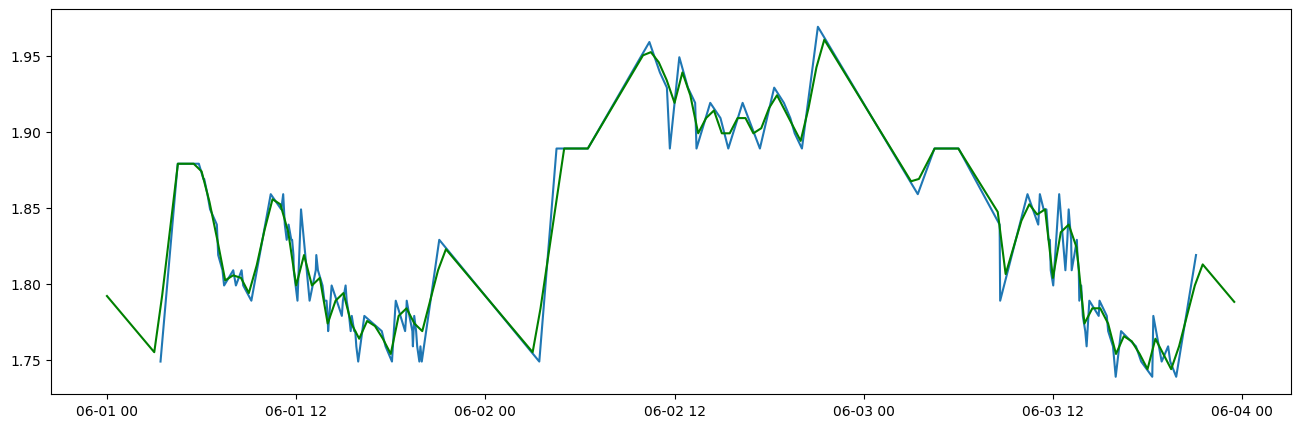

In [87]:
plt.figure(figsize=(16, 5))

plt.plot(df['e5']['2024-06-01':'2024-06-03'])
plt.plot(interpolated_df['e5']['2024-06-01':'2024-06-03'], 'g')

plt.show()

In [88]:
rolling_mean_filter = RollingMeanFilter(window_size=3)
rolling_mean_df = rolling_mean_filter.fit_transform(interpolated_df)

rolling_mean_df.head()

,e5
2023-01-01 04:30:00+00:00,1.692979
2023-01-01 05:00:00+00:00,1.749000
2023-01-01 05:30:00+00:00,1.816161
2023-01-01 06:00:00+00:00,1.821000
2023-01-01 06:30:00+00:00,1.758222


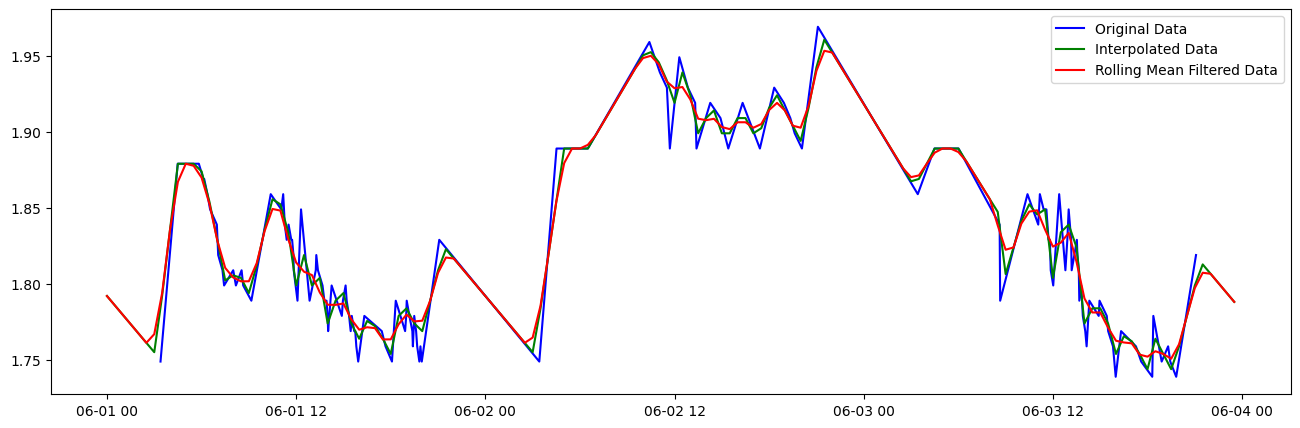

In [89]:
plt.figure(figsize=(16, 5))

plt.plot(df['e5']['2024-06-01':'2024-06-03'], 'b', label='Original Data')
plt.plot(interpolated_df['e5']['2024-06-01':'2024-06-03'], 'g', label='Interpolated Data')
plt.plot(rolling_mean_df['e5']['2024-06-01':'2024-06-03'], 'r', label='Rolling Mean Filtered Data')

plt.legend()

plt.show()

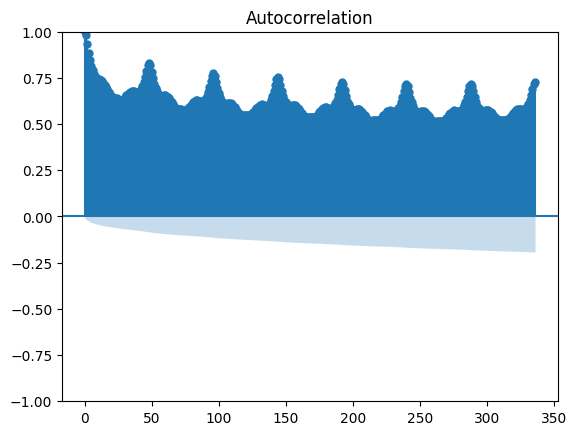

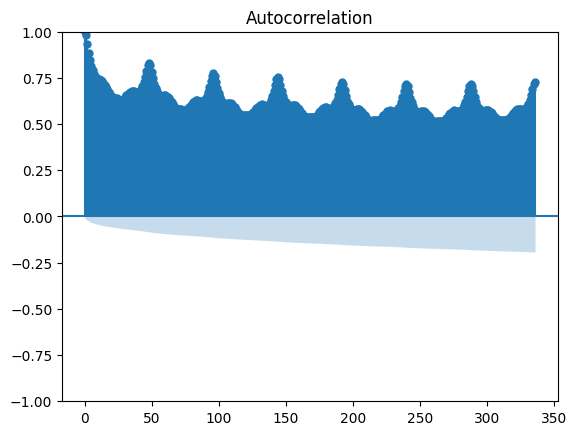

In [90]:
plot_acf(rolling_mean_df, lags=2*24*7)

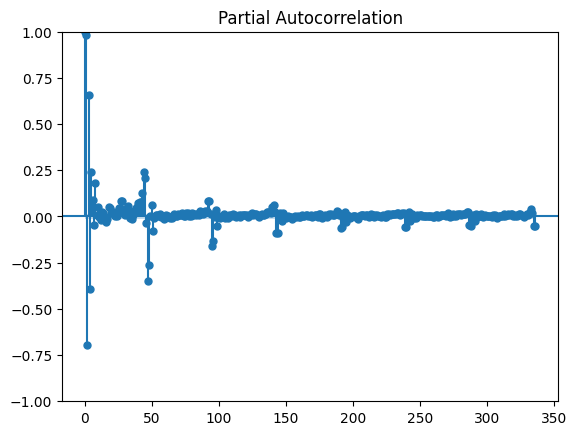

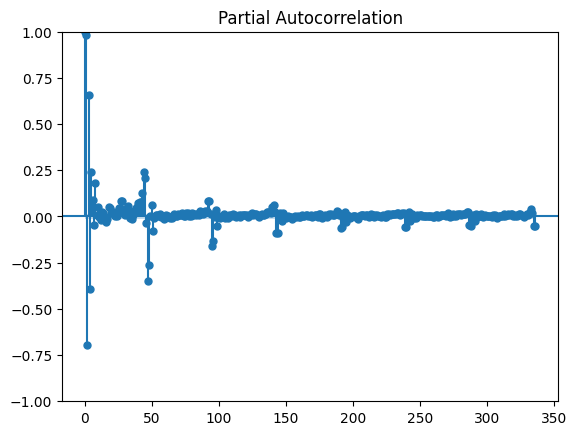

In [91]:
plot_pacf(rolling_mean_df, lags=2*24*7)

In [187]:
train, test, _, _ = train_test_split(interpolated_df, interpolated_df, shuffle=False, test_size=0.1)

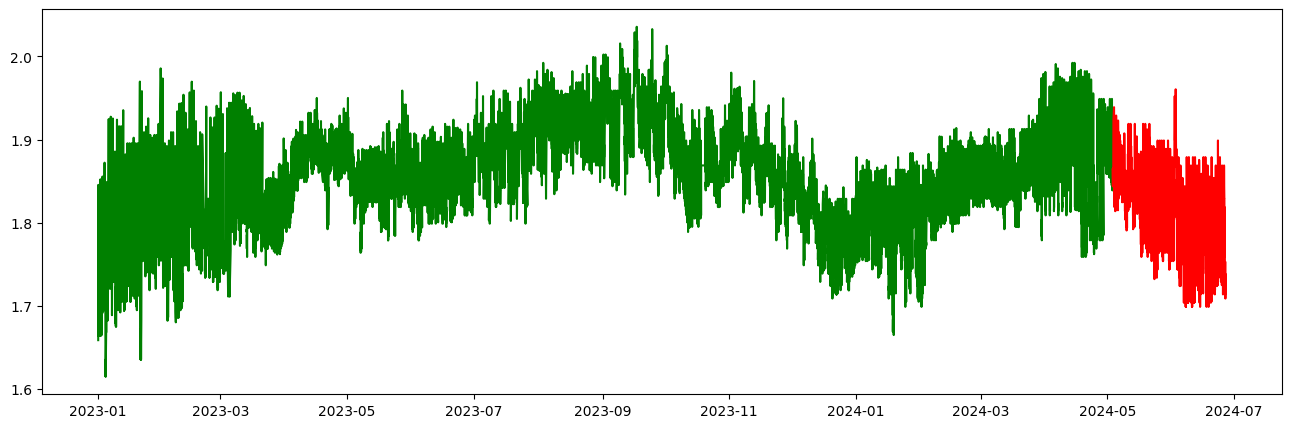

In [188]:
plt.figure(figsize=(16, 5))

plt.plot(train, 'g')
plt.plot(test, 'r')

plt.show()

In [189]:
train = train.values
test = test.values

In [190]:
class MeanBaselineEstimator(BaseEstimator, RegressorMixin):
    def __init__(self):
        self.mean = None
        
    def fit(self, X, y):
        self.mean = y.mean()
        return self
    
    def predict(self, X):
        return [self.mean] * len(X)

In [237]:
model = MeanBaselineEstimator()
model.fit(train, train)

MeanBaselineEstimator()

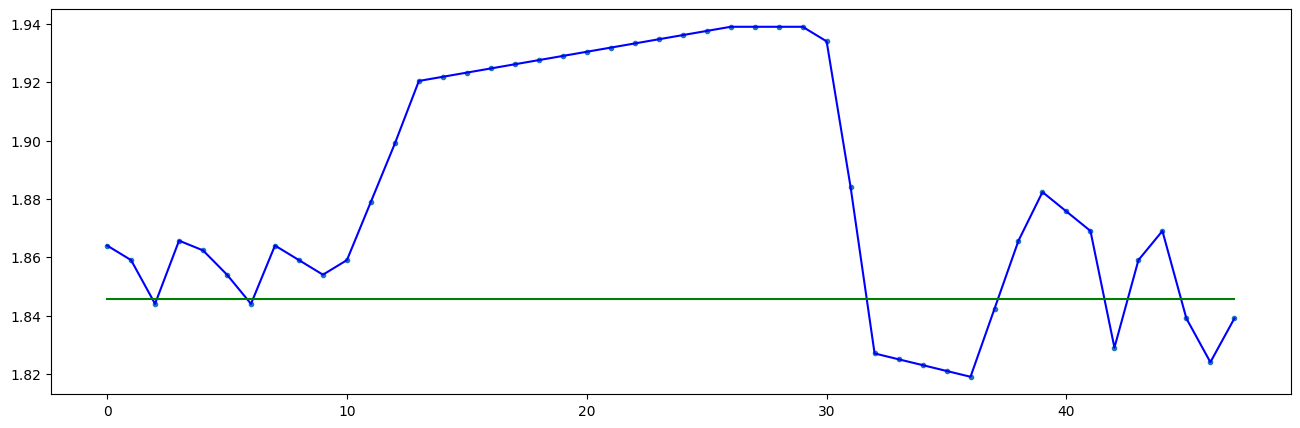

In [238]:
predictions = model.predict(test[:2*24])

plt.figure(figsize=(16, 5))

plt.plot(test[:2*24], '.')
plt.plot(test[:2*24], 'b')
plt.plot(predictions, 'g')

plt.show()

In [239]:
print('MSE:', mean_squared_error(test[:2*24], predictions))
print('MAE:', mean_absolute_error(test[:2*24], predictions))
print('MAPE:', mean_absolute_percentage_error(test[:2*24], predictions))
print('R2:', r2_score(test[:2*24], predictions))

MSE: 0.003075793014298658
MAE: 0.04406444604393251
MAPE: 0.023050817124776534
R2: -0.7900207913221389


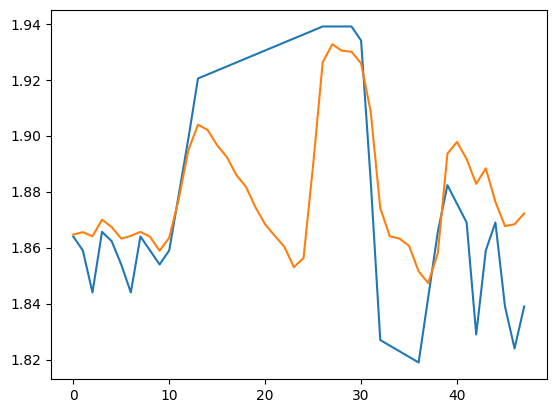

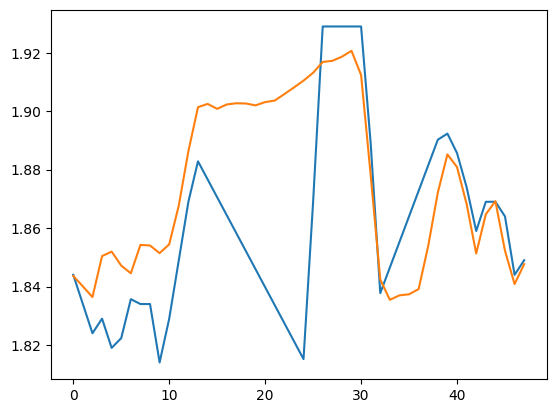

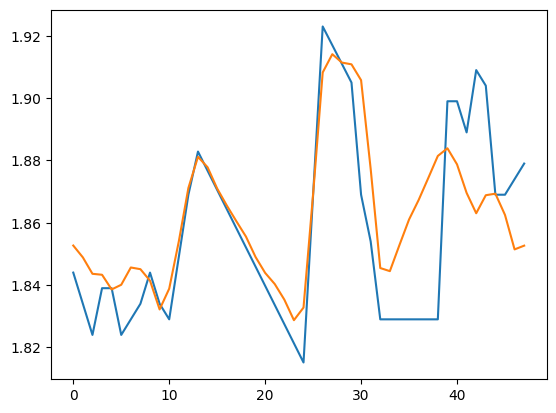

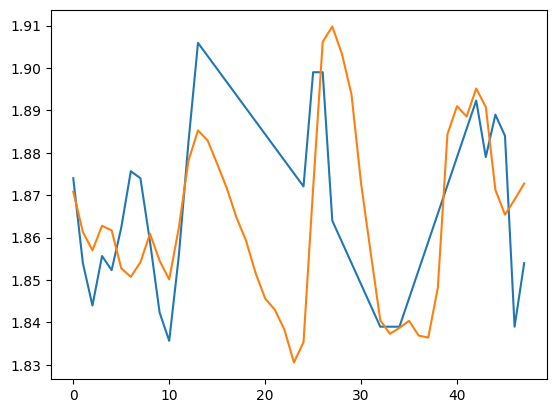

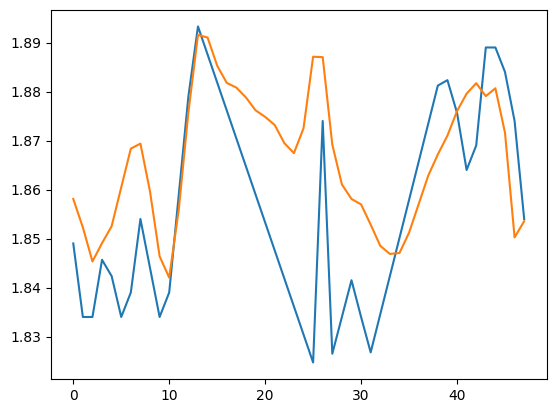

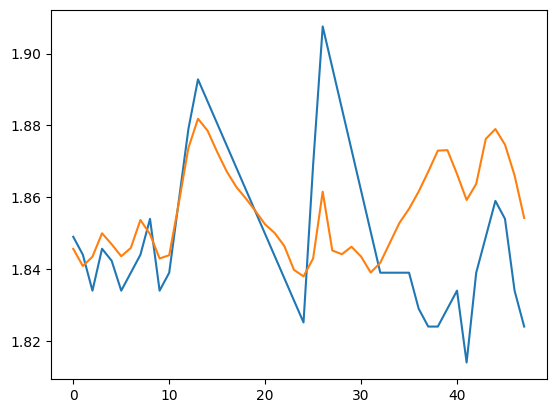

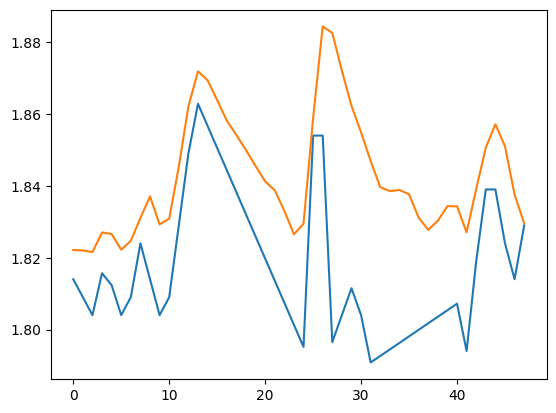

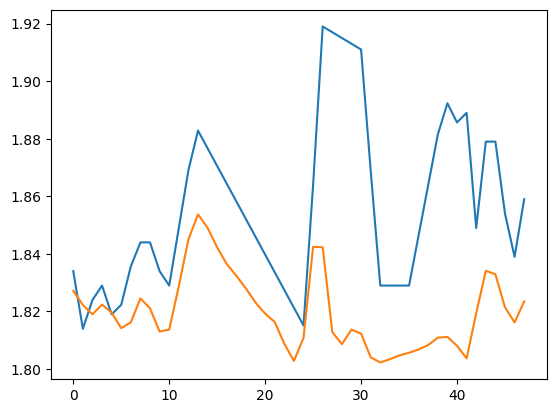

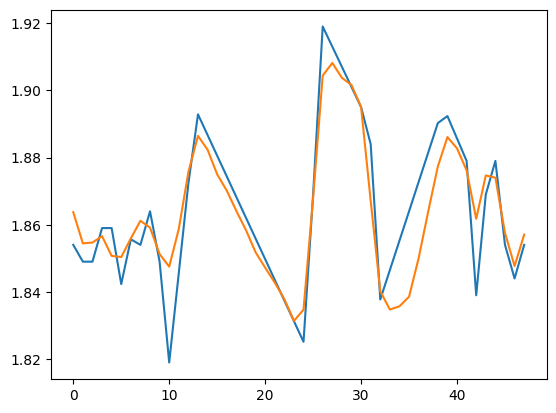

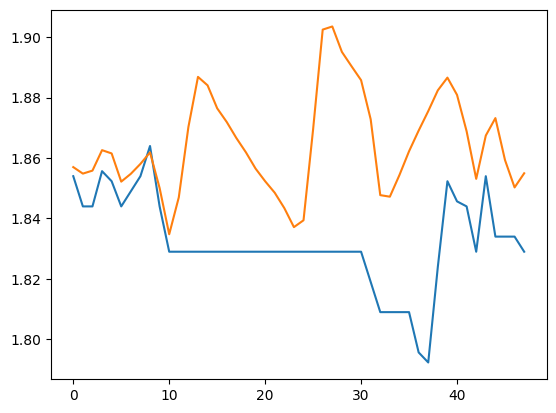

In [253]:
history = train.copy()
for idx in range(10):
    model = ARIMA(history, order=(50, 1, 0))
    model_fit = model.fit() 
    predictions = model_fit.forecast(2*24)
    history = np.append(history, test[idx*2*24:(idx + 1)*2*24])

    plt.plot(test[idx*2*24:(idx + 1)*2*24])
    plt.plot(predictions)

    plt.show()

In [236]:
print('MSE:', mean_squared_error(test[:2*24], predictions))
print('MAE:', mean_absolute_error(test[:2*24], predictions))
print('MAPE:', mean_absolute_percentage_error(test[:2*24], predictions))
print('R2:', r2_score(test[:2*24], predictions))

MSE: 0.0011926953226570759
MAE: 0.026453600744465584
MAPE: 0.01400281613310697
R2: 0.3058865094809887
